<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***15% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-09 to 2025-06-06
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-06.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 1000 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 999 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 998 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 999 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14996


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""META""","""2025-06-08 13:10:05""","""Meta To Dump $10 Billion Into …","""https://images.financialmodeli…","""247wallst.com""","""Meta Is Making AI Investment S…","""https://247wallst.com/technolo…"
"""TOP""","""2025-06-08 13:03:00""","""ROSEN, A TOP RANKED INVESTOR R…","""https://images.financialmodeli…","""globenewswire.com""","""NEW YORK, June 08, 2025 (GLOBE…","""https://www.globenewswire.com/…"
"""NVDA""","""2025-06-08 13:00:23""","""Mag 7 Giving AVGO New Edge Ove…","""https://images.financialmodeli…","""youtube.com""","""Cory Johnson sees Broadcom's (…","""https://www.youtube.com/watch?…"
"""LPRO""","""2025-06-08 13:00:00""","""Class Action Lawsuit Filed Aga…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""DNUT""","""2025-06-08 13:00:00""","""Class Action Filed Against Kri…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

Loading fundamental data...
Loaded 504 stocks, 4247 unique tickers
Analyzing sentiment for stock symbols...

Screened 1690 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BRT""",4,0.8156,0.0,1.0,0.6313,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",16,0.8039,0.0,1.0,0.6077,16,0.4898,0.5627,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""HBFG""",5,0.7819,0.0,1.0,0.5638,5,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""ACNB""",4,0.7604,0.0,1.0,0.5208,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""WPM""",3,0.7514,0.0,1.0,0.5028,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",30,0.581613,0.551097,15.7,4.1586e10,21.161
"""Consumer Defensive""",32,0.571669,0.540122,18.8125,1.0309e11,NaN
"""Healthcare""",57,0.567688,0.493847,14.701754,8.5815e10,NaN
"""Industrials""",56,0.56573,0.514743,10.464286,6.2477e10,NaN
"""Technology""",74,0.565028,0.476696,17.391892,2.2426e11,NaN
…,…,…,…,…,…,…
"""Consumer Cyclical""",47,0.562702,0.489751,14.638298,1.2291e11,NaN
"""Communication Services""",20,0.559155,0.51557,22.7,3.7854e11,NaN
"""Financial Services""",57,0.557604,0.478051,13.280702,1.0272e11,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['MMC', 'AMAT', 'TMUS', 'MRK', 'APO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",16,0.8039,0.0,1.0,0.6077,16,0.4898,0.5627,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""EXC""",3,0.7287,0.0,1.0,0.4574,3,0.5511,0.5816,"""Utilities""",4.4238e10,16.29,43.82
"""DTE""",8,0.7265,0.0,1.0,0.453,8,0.5511,0.5816,"""Utilities""",2.8357e10,18.44,136.65
"""USB""",3,0.7181,0.0,1.0,0.4361,3,0.4781,0.5576,"""Financial Services""",6.7915e10,10.79,43.59
"""HWM""",5,0.7009,0.0,1.0,0.4018,5,0.5147,0.5657,"""Industrials""",6.8580e10,55.52,169.89



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",21,0.2333,0.616643,0.705224
"""Industrials""",16,0.243075,0.621544,0.773169
"""Healthcare""",11,0.264764,0.632382,0.773373
"""Consumer Cyclical""",9,0.2851,0.642544,0.830867
"""Utilities""",8,0.297775,0.6488875,0.80705



Summary statistics for selected stocks:
Average sentiment score: 0.2472
Min sentiment score: 0.1658
Max sentiment score: 0.6077
Average company news score: 0.6236
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import load_and_filter_data

quotes = load_and_filter_data('data/daily_stock_quotes.csv', screened_tickers, start_date, end_date)
# quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
quotes = quotes.dropna(axis=1, how='any').dropna(axis=0, how='any')
available_tickers = quotes.columns.tolist()

print(f"Available tickers after cleaning: {available_tickers}")
print(f"Dataset shape after cleaning: {quotes.shape}")
print(f"Date range: {quotes.index[0]} to {quotes.index[-1]}")
display(quotes.head())

Found 99 of 100 tickers in data/daily_stock_quotes.csv
Missing tickers: ['GEV']
Available tickers after cleaning: ['ACN', 'ADBE', 'ADI', 'AES', 'ALB', 'ALL', 'ATO', 'BA', 'BAC', 'BBY', 'BK', 'BKNG', 'CB', 'CDNS', 'CL', 'CLX', 'CMCSA', 'CMS', 'CNC', 'CNP', 'CPB', 'CTAS', 'DAL', 'DPZ', 'DTE', 'DVN', 'EL', 'EMR', 'ENPH', 'EQT', 'EXC', 'FAST', 'FI', 'FICO', 'FOX', 'FRT', 'GE', 'GEN', 'GILD', 'GOOGL', 'GRMN', 'GS', 'HAS', 'HCA', 'HD', 'HOLX', 'HWM', 'INTC', 'INTU', 'KIM', 'LRCX', 'LUV', 'MCHP', 'MCK', 'MDLZ', 'MDT', 'MOH', 'MSFT', 'MTCH', 'MU', 'NEM', 'NOC', 'NOW', 'NRG', 'NTAP', 'NVR', 'O', 'OKE', 'OXY', 'PANW', 'PEG', 'PEP', 'PH', 'PLD', 'REG', 'RF', 'ROK', 'RTX', 'SBUX', 'SLB', 'SMCI', 'SNPS', 'SYK', 'TJX', 'TRV', 'TXN', 'UAL', 'ULTA', 'UNP', 'USB', 'VRTX', 'VZ', 'WELL', 'WMT', 'ZTS']
Dataset shape after cleaning: (2512, 95)
Date range: 2015-06-10 00:00:00 to 2025-06-04 00:00:00


,ACN,ADBE,ADI,AES,ALB,ALL,ATO,BA,BAC,BBY,...,TXN,UAL,ULTA,UNP,USB,VRTX,VZ,WELL,WMT,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-10,81.94,79.559998,55.44,9.25,53.18,53.93,40.78,125.428864,14.28,24.42,...,41.24,52.419998,154.979996,80.07,31.62,125.180,28.42,45.88,20.09,46.09
2015-06-11,82.28,79.650000,55.03,9.39,53.43,54.39,41.10,126.615631,14.20,24.41,...,40.82,52.500000,155.369995,81.08,31.65,126.350,28.59,45.96,20.10,46.25
2015-06-12,81.59,79.860000,54.24,9.27,52.22,54.30,40.72,126.473938,14.20,24.41,...,40.34,52.869999,155.320000,80.74,31.60,124.360,28.28,45.64,19.96,45.52
2015-06-15,81.32,78.900000,54.60,9.33,50.59,53.73,40.69,126.022232,14.18,24.35,...,40.37,52.250000,154.570000,80.76,31.33,123.495,28.14,45.35,19.82,45.70
2015-06-16,82.09,79.940000,54.54,9.43,50.64,54.26,41.09,126.066536,14.25,24.54,...,40.40,51.230000,155.500000,80.76,31.47,123.340,28.39,45.67,19.93,46.11


### Step 7: Split Data into Training and Testing Sets

In [10]:
# Split data into 80% training and 20% testing based on date
total_rows = len(quotes)
train_size = int(0.8 * total_rows)
training_set = quotes.iloc[:train_size]
test_set = quotes.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2009 rows (80.0%) | Testing: 503 rows (20.0%)
Training period: 2015-06-10 00:00:00 to 2023-06-01 00:00:00
Testing period: 2023-06-02 00:00:00 to 2025-06-04 00:00:00


### Step 8: Find Best Strategy -- Training Set
- Backtest & Optimize Strategies (Loop through different parameters)
- Select Top Stocks ***(by Sortino Ratio)***

In [11]:
daily_risk_free_df.columns.str.title()

daily_risk_free_df

,^IRX
Date,
2015-06-10,0.013
2015-06-11,0.008
2015-06-12,0.005
2015-06-15,0.003
2015-06-16,0.008
...,...
2025-05-29,4.230
2025-05-30,4.230
2025-06-02,4.230


,Ticker,Strategy,Best_Sharpe,Best_Sortino,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,MSFT,SMA_Cross_Signal,1.086255,1.438083,0.295258,-0.280423,0.272451,85,125
1,NOC,SMA_Cross_Signal,0.856429,1.104462,0.196998,-0.335029,0.245245,85,125


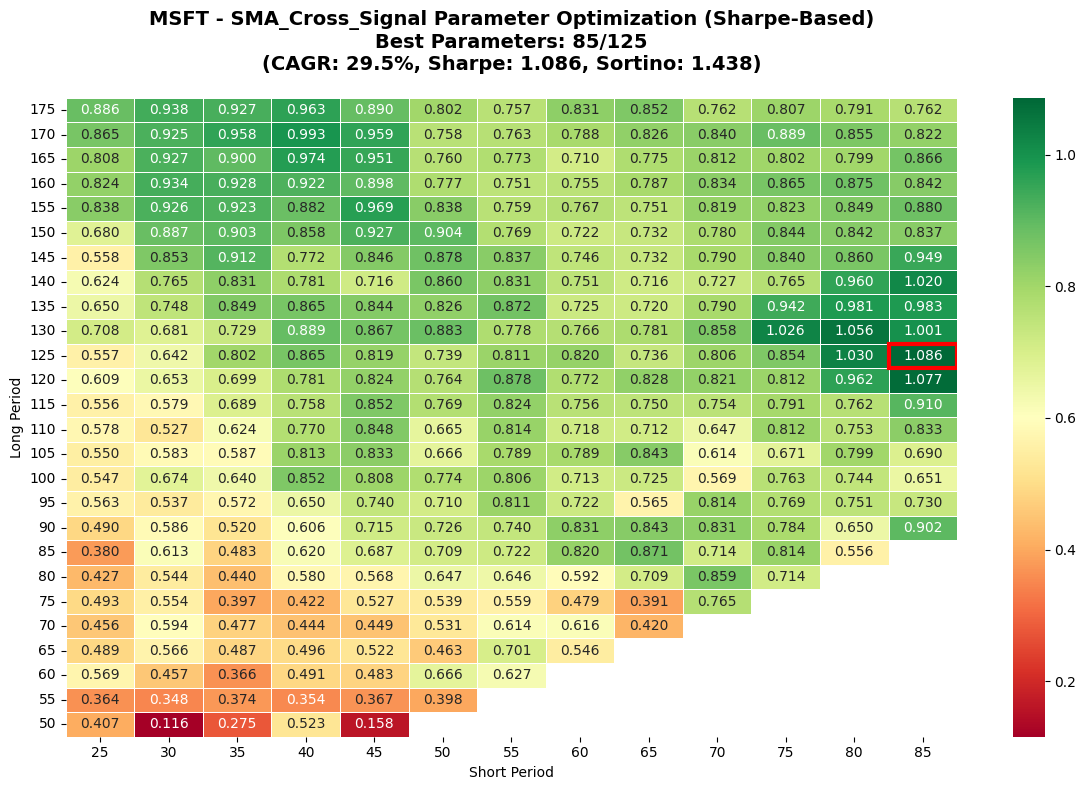

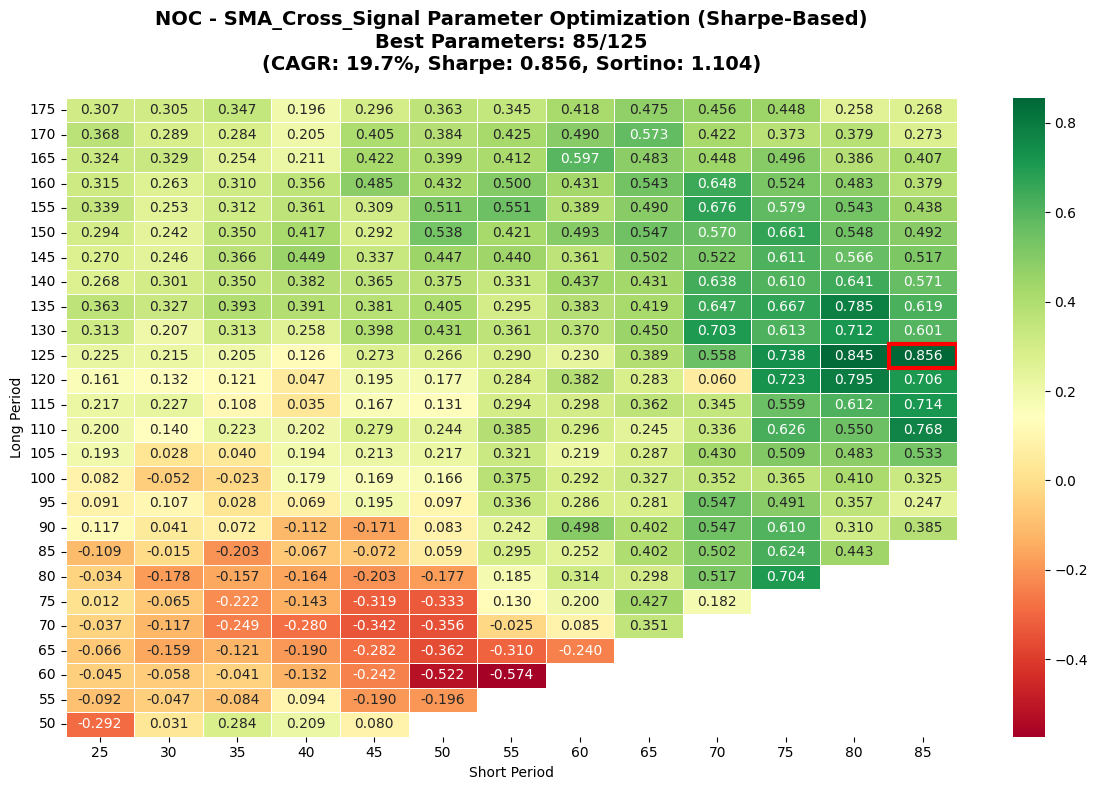

In [12]:
# In your notebook cell, update the optimization call:
from py.technical_analysis import find_optimal_portfolio_with_parameter_optimization, plot_optimization_heatmaps

performance_metric = 'sharpe' # Choose: 'cagr', 'sharpe', or 'sortino'
max_stocks = 2            # Top N stocks by performance metric

# Define Parameter ranges
# parameter_ranges = {
#     'SMA_Cross_Signal': {
#         'short_periods': [10, 15, 20, 25, 30, 35, 40],
#         'long_periods': [60, 80, 100, 120, 140, 160, 180, 200]
#     },
#     'EMA_Cross_Signal': {
#         'short_periods': [8, 12, 16, 20, 24, 28],
#         'long_periods': [35, 40, 45, 50, 55, 60, 65]
#     }
# }

parameter_ranges = {
    'SMA_Cross_Signal': {
        'short_periods': list(range(25, 90, 5)),
        'long_periods': list(range(50, 180, 5))     
    },
    'EMA_Cross_Signal': {
        'short_periods': list(range(8, 40, 2)),      
        'long_periods': list(range(30, 80, 5))       
    }
}

# Fast optimization with custom parameter ranges
optimization_results = find_optimal_portfolio_with_parameter_optimization(
    quotes=training_set,
    # min_cagr=0.1,             # Minimum 10% annual return
    # max_volatility=0.3,       # Maximum 30% volatility
    max_stocks=max_stocks,    # Top 2 stocks by Sortino ratio
    n_jobs=4,                 # Parallel processing cores
    heatmap_metric=performance_metric,
    parameter_ranges=parameter_ranges 
)

# Access results
optimization_summary = optimization_results['optimization_summary']
portfolio_stats = optimization_results['portfolio_stats']
selected_tickers = optimization_results['selected_tickers']

display(optimization_summary)

# Plot heatmaps with different metrics:
plot_optimization_heatmaps(optimization_results, metric=performance_metric)

### Step 9: Test the Strategy -- Testing Set

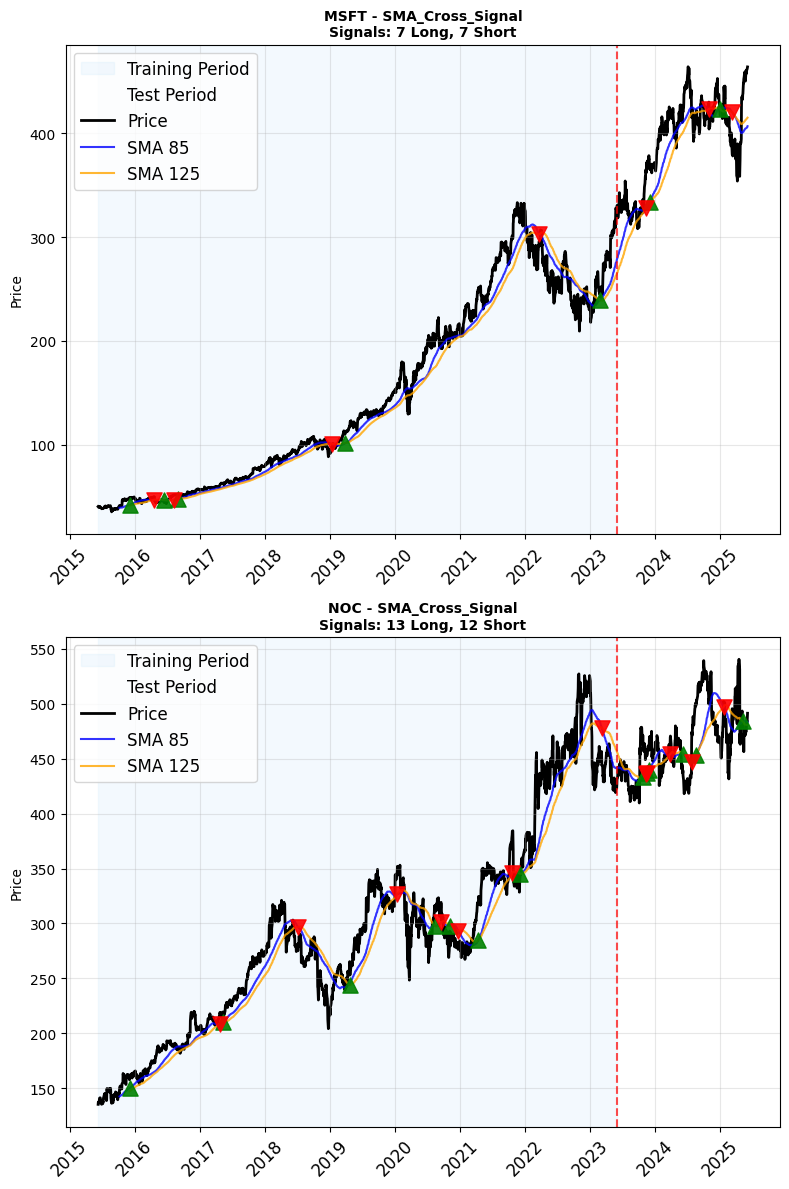

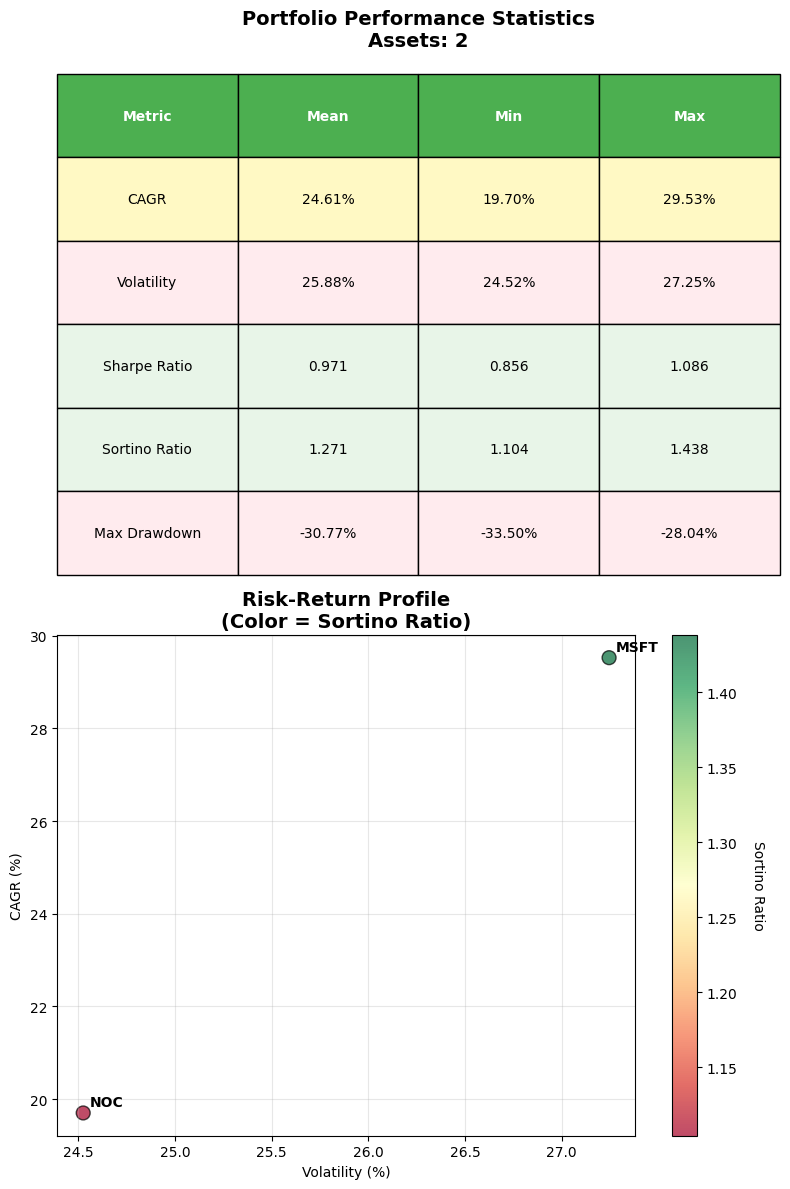

Selected tickers: ['MSFT', 'NOC']
Portfolio weights type: <class 'pandas.core.frame.DataFrame'>
Test set date range: 2023-06-02 00:00:00 to 2025-06-04 00:00:00
Portfolio test data shape: (503, 2)
Portfolio test data date range: 2023-06-02 00:00:00 to 2025-06-04 00:00:00
Final weights: {'MSFT': 0.5, 'NOC': 0.5}


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

Stat                 Short-Term (SMA) Strategy
-------------------  ---------------------------
Start                2023-06-01
End                  2025-06-04
Risk-free rate       4.24%

Total Return         29.85%
Daily Sharpe         0.63
Daily Sortino        1.04
CAGR                 13.88%
Max Drawdown         -12.70%
Calmar Ratio         1.09

MTD                  1.05%
3m                   13.42%
6m                   5.07%
YTD                  8.96%
1Y                   13.80%
3Y (ann.)            13.88%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  13.88%

Daily Sharpe         0.63
Daily Sortino        1.04
Daily Mean (ann.)    14.39%
Daily Vol (ann.)     16.15%
Daily Skew           0.37
Daily Kurt           8.89
Best Day             7.08%
Worst Day            -5.25%

Monthly Sharpe       0.73
Monthly Sortino      1.56
Monthly Mean (ann.)  12.71%
Monthly Vol (ann.)   11.74%
Monthly Skew         0.33
Monthly Kurt         -0.25
Best Month           8.00%
Wors

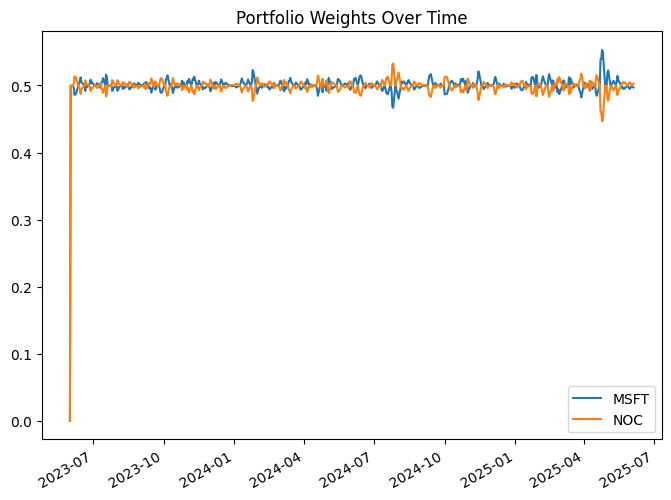

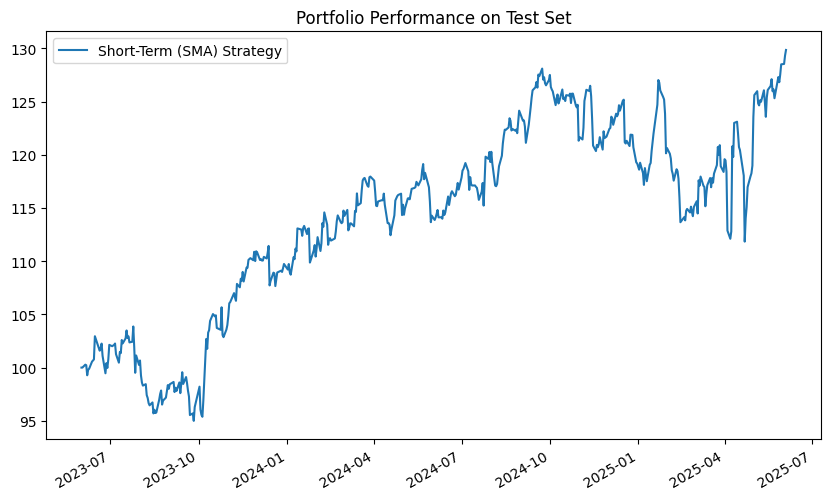

In [13]:
from py.technical_analysis import plot_portfolio_performance, plot_complete_strategy_analysis

# Generate and plot complete strategy analysis
plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=1) # 1 column layout (vertical stack)
# plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=2, rows=2) # Fixed 2x2 grid
plot_portfolio_performance(optimization_summary, cols=1, rows=2)  # 2 columns to show both table AND risk-return profile

# Use the portfolio result from optimization_results
if 'portfolio_result' in optimization_results:
    optimization_results['portfolio_result'].plot_security_weights()
    portfolio_result = optimization_results['portfolio_result']
else:
    # Alternative: Create a quick portfolio backtest to get weights
    portfolio_weights = optimization_results['portfolio_weights']
    selected_tickers = optimization_results['selected_tickers']
    
    # Debug: Check what we have
    print(f"Selected tickers: {selected_tickers}")
    print(f"Portfolio weights type: {type(portfolio_weights)}")
    print(f"Test set date range: {test_set.index[0]} to {test_set.index[-1]}")
    
    # Create a subset of quotes for selected tickers
    portfolio_quotes = quotes[selected_tickers].dropna()
    
    # Filter portfolio_quotes by test_set date range (use .loc for date filtering)
    portfolio_test_data = portfolio_quotes.loc[test_set.index]
    
    print(f"Portfolio test data shape: {portfolio_test_data.shape}")
    print(f"Portfolio test data date range: {portfolio_test_data.index[0]} to {portfolio_test_data.index[-1]}")
    
    # Handle portfolio_weights properly
    if isinstance(portfolio_weights, pd.DataFrame):
        # Extract weights - check if it's a DataFrame with weights
        if len(portfolio_weights) == len(selected_tickers):
            # Assuming each row corresponds to a ticker
            weights_dict = {ticker: portfolio_weights.iloc[i, 0] for i, ticker in enumerate(selected_tickers)}
        else:
            # Equal weights fallback
            weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}
    elif isinstance(portfolio_weights, dict):
        weights_dict = {ticker: portfolio_weights.get(ticker, 1.0/len(selected_tickers)) for ticker in selected_tickers}
    else:
        # Equal weights fallback
        weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}
    
    # Normalize weights to sum to 1
    total_weight = sum(weights_dict.values())
    if total_weight > 0:
        weights_dict = {k: v/total_weight for k, v in weights_dict.items()}
    
    print(f"Final weights: {weights_dict}")
    
    # Create and run portfolio backtest
    portfolio_strategy = bt.Strategy('Short-Term (SMA) Strategy', 
                     [
                         bt.algos.RunWeekly(),                 
                         bt.algos.SelectAll(),
                         bt.algos.WeighSpecified(**weights_dict),  # Unpack the dictionary       
                         bt.algos.Rebalance()
                     ]
                 )     
    
    # Run backtest on the filtered test data
    portfolio_backtest = bt.Backtest(portfolio_strategy, portfolio_test_data)
    portfolio_result = bt.run(portfolio_backtest)
    
    # Set risk-free rate if available
    if 'risk_free_rate' in globals():
        portfolio_result.set_riskfree_rate(risk_free_rate)

# Display results
if 'portfolio_result' in locals():
    # With custom parameters
    portfolio_result.plot_security_weights(
        figsize=(8, 6),
        title='Portfolio Weights Over Time'
    )
    
    portfolio_result.display()
    
    # Additional performance plot
    portfolio_result.plot(figsize=(10, 6), title='Portfolio Performance on Test Set')
else:
    print("Portfolio result not available")

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [14]:
from py.utils import clean_column_names

# Use optimization_results instead of analysis_results
print("Selected tickers from optimization_results:")
print(selected_tickers)

# Create a DataFrame with tickers and merge with optimization_summary
optimization_summary_with_tickers = optimization_summary.copy()
optimization_summary_with_tickers['Ticker'] = [ticker.upper() for ticker in selected_tickers]

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(optimization_summary_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)

# Add weights based on Sortino Ratio (assuming this column exists in the data)
if 'sortino_ratio' in short_term_portfolio_df.columns:
    # Normalize Sortino ratios to create weights
    sortino_sum = short_term_portfolio_df['sortino_ratio'].sum()
    short_term_portfolio_df['Weight'] = short_term_portfolio_df['sortino_ratio'] / sortino_sum
else:
    # Fallback to equal weights if Sortino ratio not available
    short_term_portfolio_df['Weight'] = 1.0 / len(short_term_portfolio_df)

# Verify weights sum to 1
print(f"Total portfolio weight: {short_term_portfolio_df['Weight'].sum():.6f}")

display(short_term_portfolio_df)

Selected tickers from optimization_results:
['MSFT', 'NOC']
Total portfolio weight: 1.000000


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
Ticker,,,,,,,,,,,,,,,,,,,,,
MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3.421644e+12,3.447047e+12,7.422064e+09,7.432540e+09,...,85,125,42,0.5954,0.0476,0.619,0.1909,0.4767,0.5650,0.5
NOC,2025-06-02,Northrop Grumman Corporation,Industrials,Aerospace & Defense,United States,https://www.northropgrumman.com,6.977198e+10,8.621307e+10,1.351630e+08,1.439280e+08,...,85,125,3,0.6516,0.0000,1.000,0.3031,0.5147,0.5657,0.5


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [15]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,MSFT,NOC,^IRX
Date,,,
2025-06-01,463.87,491.29,4.240
2025-05-01,460.36,484.77,4.230
2025-04-01,394.54,486.50,4.190
2025-03-01,374.70,512.01,4.190
2025-02-01,396.26,459.68,4.193
...,...,...,...
2015-10-01,45.94,161.16,0.068
2015-09-01,38.63,142.45,0.005
2015-08-01,37.98,140.55,0.003


#### Export DataFrame to Excel

In [16]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-06.xlsx
